# Libraries


In [ ]:
pip install tensorflow

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl (149.9 MB)


# Face Dectection

**Haar Cascade**

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# Webcam Capturing

**Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

# function convert Javascript object in to OpenCv_image
def js_to_image(js_reply):
  #js_reply: javascript image from webcam
  #Open CV RBG image

  #decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  #convert byte to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img


# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  #bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  #bytes: Base64 image byte string
  
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes



**Webcam Data**

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality){
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

        // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

 # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  """
  *** Face Detection ***
 
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

  """    
  # save image
  cv2.imwrite(filename, img)

  return filename

**Capture**

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  import os
  print( os.getcwd() )
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


SyntaxError: ignored

# Neural Style


**PyTorch Setup**

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import sys

# Configures repo in local colab fs
REPO_DIR = '/demo'
%mkdir -p "$REPO_DIR"
%cd "$REPO_DIR" 
%rm -rf examples
!git clone https://github.com/pytorch/examples.git 
%cd "$REPO_DIR/examples/fast_neural_style"

# Download pretrained weights for styles
!python download_saved_models.py
%cd "$REPO_DIR/examples/fast_neural_style/neural_style"

## Creates pre-trained style networks
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import utils
from transformer_net import TransformerNet
from vgg import Vgg16

# Acquires the XLA device (a TPU core)
device = xm.xla_device()

# Loads pre-trained weights
rain_princess_path = '../saved_models/rain_princess.pth'
candy_path = '../saved_models/candy.pth'
mosaic_path = '../saved_models/mosaic.pth'
udnie_path = '../saved_models/udnie.pth'

# Loads the pre-trained weights into the fast neural style transfer
# network architecture and puts the network on the Cloud TPU core.
def load_style(path):
  with torch.no_grad():
    model = TransformerNet()
    state_dict = torch.load(path)
    # filters deprecated running_* keys from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    model.load_state_dict(state_dict)
    return model.to(device)

# Creates each fast neural style transfer network
rain_princess = load_style(rain_princess_path)
candy = load_style(candy_path)
mosaic = load_style(mosaic_path)
udnie = load_style(udnie_path)

/demo
Cloning into 'examples'...
remote: Enumerating objects: 2876, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 2876 (delta 3), reused 6 (delta 1), pack-reused 2863
Receiving objects: 100% (2876/2876), 39.18 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (1439/1439), done.
/demo/examples/fast_neural_style
100% 23.9M/23.9M [00:00<00:00, 65.4MB/s]
/demo/examples/fast_neural_style/neural_style


**Insert Image URL**

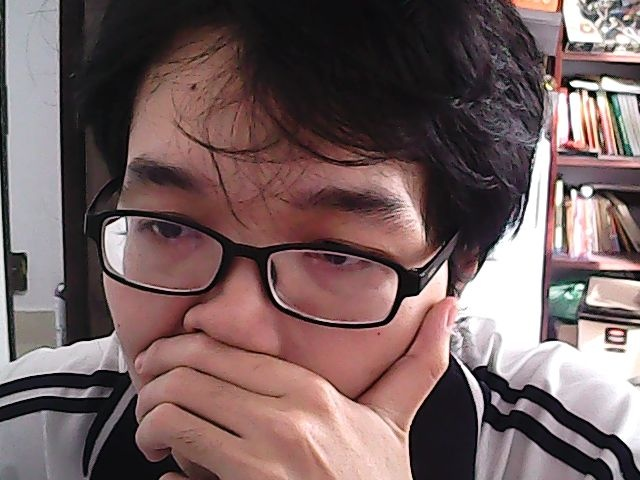

In [ ]:
content_image = '/content/photo.jpg'
RESULT_IMAGE = '/content/result.jpg'
!rm -f "$RESULT_IMAGE"
img = cv2.imread(content_image, cv2.IMREAD_UNCHANGED)

content_image = utils.load_image(content_image, scale=None)
content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)

cv2_imshow(img)

**PyTorch Fast Neural Style Transfer**

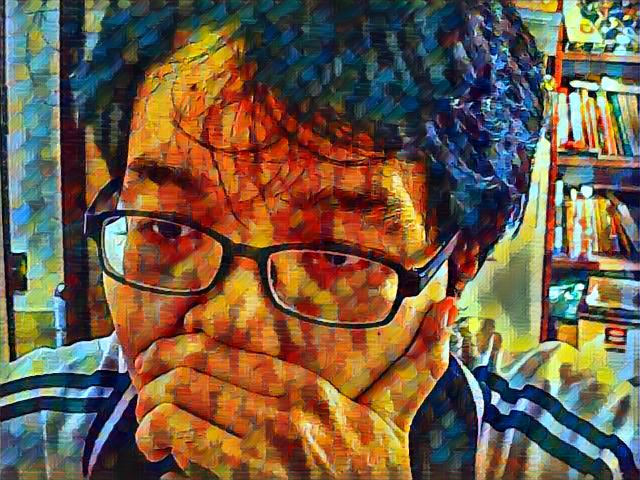

In [ ]:
with torch.no_grad():
   output = rain_princess(content_image)  
  # output = candy(content_image)
  # output = mosaic(content_image)
  # output = udnie(content_image)


utils.save_image(RESULT_IMAGE, output[0].cpu())
img = cv2.imread(RESULT_IMAGE, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

# Background Change


**Background And Image Import**

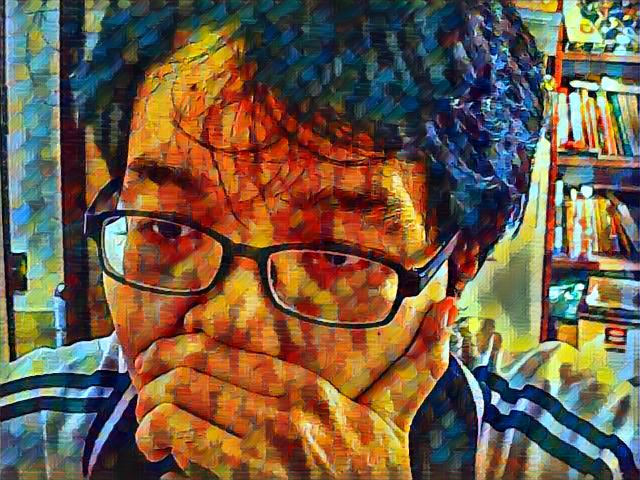

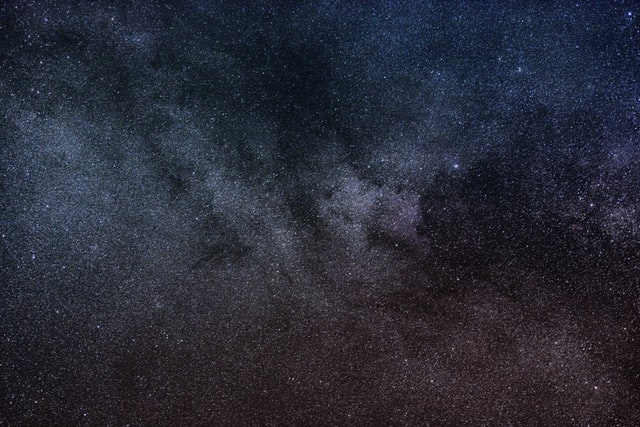

In [ ]:
import cv2
from urllib.request import urlretrieve
from google.colab.patches import cv2_imshow

# save the background to our local storage
urlretrieve('https://images.unsplash.com/photo-1475139441338-693e7dbe20b6?auto=format&fit=crop&w=640&q=427', '/content/background.jpg')

# display the images in the notebook
cv2_imshow(cv2.imread('/content/photo.jpg'))
cv2_imshow(cv2.imread('/content/background.jpg'))

**DeepLabV3-ResNet101 Setup**

In [ ]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

**Foreground Cut**

In [ ]:
import numpy as np
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, '/content/photo.jpg')
plt.imshow(bin_mask)

In [ ]:
plt.imshow(foreground)

In [ ]:
Image.fromarray(foreground).save("/content/foreground.png")

**Background Custom**

In [ ]:
def custom_background(background_file, foreground):
  final_foreground = Image.fromarray(foreground)
  background = Image.open(background_file)
  x = (background.size[0]-final_foreground.size[0])/2
  y = (background.size[1]-final_foreground.size[1])/2
  box = (x, y, final_foreground.size[0] + x, final_foreground.size[1] + y)
  crop = background.crop(box)
  final_image = crop.copy()
  # put the foreground in the centre of the background
  paste_box = (0, final_image.size[1] - final_foreground.size[1], final_image.size[0], final_image.size[1])
  final_image.paste(final_foreground, paste_box, mask=final_foreground)
  return final_image

In [ ]:
final_image = custom_background('/content/background.jpg', foreground)
plt.imshow(final_image)

In [ ]:
final_image.save("/content/final.jpg")